# Linear Regression, Leadtime Testing

Train a linear regression model to predict AMV at specified leadtimes.

Uses data that has been preprocessed by "output_normalized_data.ipynb"
in /Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os
from numpy.linalg import inv

In [2]:
# User Edits
leads          = np.arange(0,25,1)    # Time ahead (in years) to forecast AMV
resolution     = '2deg'               # Resolution of input (2deg or full)
season         = 'Ann'                # Season to take mean over
indexregion    = 'NAT'                # One of the following ("SPG","STG","TRO","NAT")
outpath        = os.getcwd()

# Training/Testing Subsets
percent_train = 0.8   # Percentage of data to use for training (remaining for testing)
ens           = 40    # Ensemble members to use
channels      = 3

In [49]:
# Functions
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index


def make_classes(y,thresholds,exact_value=False,reverse=False):
    """
    Makes classes based on given thresholds. 

    Parameters
    ----------
    y : ARRAY
        Labels to classify
    thresholds : ARRAY
        1D Array of thresholds to partition the data
    exact_value: BOOL, optional
        Set to True to use the exact value in thresholds (rather than scaling by
                                                          standard deviation)

    Returns
    -------
    y_class : ARRAY [samples,class]
        Classified samples, where the second dimension contains an integer
        representing each threshold

    """
    nthres = len(thresholds)
    if exact_value is False: # Scale thresholds by standard deviation
        y_std = np.std(y) # Get standard deviation
        thresholds = np.array(thresholds) * y_std
    y_class = np.zeros((y.shape[0],1))
    
    if nthres == 1: # For single threshold cases
        thres = thresholds[0]
        y_class[y<=thres] = 0
        y_class[y>thres] = 1
        
        print("Class 0 Threshold is y <= %.2f " % (thres))
        print("Class 0 Threshold is y > %.2f " % (thres))
        return y_class
    
    for t in range(nthres+1):
        if t < nthres:
            thres = thresholds[t]
        else:
            thres = thresholds[-1]
        
        if reverse: # Assign class 0 to largest values
            tassign = nthres-t
        else:
            tassign = t
        
        if t == 0: # First threshold
            y_class[y<=thres] = tassign
            print("Class %i Threshold is y <= %.2f " % (tassign,thres))
        elif t == nthres: # Last threshold
            y_class[y>thres] = tassign
            print("Class %i Threshold is y > %.2f " % (tassign,thres))
        else: # Intermediate values
            thres0 = thresholds[t-1]
            y_class[(y>thres0) * (y<=thres)] = tassign
            print("Class %i Threshold is %.2f < y <= %.2f " % (tassign,thres0,thres))
    return y_class

In [4]:
# Load the data for whole North Atlantic
sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
sss_normed = np.load('../../CESM_data/CESM_sss_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
psl_normed = np.load('../../CESM_data/CESM_psl_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
invars = [sst_normed,sss_normed,psl_normed]

In [5]:
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
nens,tstep,nlat,nlon = sst_normed.shape

In [6]:
corr_grid_test = []
corr_grid_train = []

leads = np.arange(0,25,1)

for lead in leads:
    y = calc_AMV_index(indexregion,sst_normed[:ens,lead:,:,:],lat,lon)
    y = y.reshape((y.shape[0]*y.shape[1]))[:,None]
    X = np.transpose(
        np.array(invars)[:,:ens,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*ens,nlat,nlon),
        (1,0,2,3))
    X = np.mean(X,axis=(2,3))
    X_train =  X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].T
    X_val =  X[int(np.floor(percent_train*(tstep-lead)*ens)):,:].T
    y_train =  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:]
    y_val =  y[int(np.floor(percent_train*(tstep-lead)*ens)):,:] 

    
    theta = (inv(X_train @ X_train.T) @ X_train ) @ y_train
    y_pred_train = (theta.T @ X_train).T
    y_pred_val = (theta.T @ X_val).T
    corr_grid_train.append( np.corrcoef(y_pred_train[:,0], y_train[:,0])[0,1] )
    corr_grid_test.append( np.corrcoef(y_pred_val[:,0], y_val[:,0])[0,1] )
    

Text(0, 0.5, 'correlation')

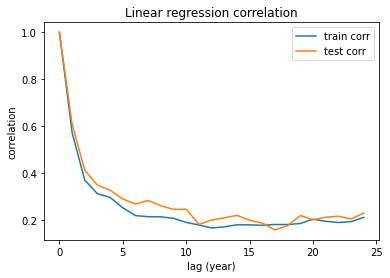

In [7]:
plt.plot(leads, corr_grid_train)
plt.plot(leads, corr_grid_test)
plt.title('Linear regression correlation')
plt.legend(['train corr','test corr'])
plt.xlabel('lag (year)')
plt.ylabel('correlation')

# Loop to train for all combinations of predictors


In [8]:

nvar       = 4
nlead      = len(leads)
netname    = "MLR"
max_epochs = 10 # Filler variable because we didn't use epochs..
expname    = "%s2deg_NAT_%s_nepoch%02i_nens%02i_lead%02i" % (season,netname,max_epochs,ens,len(leads)-1)

# Preallocate Evaluation Metrics...
corr_grid_train = np.zeros((nlead))
corr_grid_test  = np.zeros((nlead))
test_losses     = np.zeros((nlead))
train_losses    = np.zeros((nlead))

for v in range(nvar): # Loop for each variable
    # -------------------
    # Set input variables
    # -------------------
    channels = 1
    start = time.time()
    if v == 0:
        varname = 'SST'
        invars = [sst_normed]
    elif v == 1:
        varname = 'SSS'
        invars = [sss_normed]
    elif v == 2:
        varname = 'PSL'
        invars = [psl_normed]
    elif v == 3:
        channels = 3
        varname = 'ALL'
        invars = [sst_normed,sss_normed,psl_normed]
    outname = "/leadtime_testing_%s_%s.npz" % (varname,expname)
    for lead in tqdm(leads):
        
        y = calc_AMV_index(indexregion,sst_normed[:ens,lead:,:,:],lat,lon)
        y = y.reshape((y.shape[0]*y.shape[1]))[:,None]
        X = np.transpose(
            np.array(invars)[:,:ens,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*ens,nlat,nlon),
            (1,0,2,3))
        X = np.mean(X,axis=(2,3))
        X_train =  X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].T
        X_val =  X[int(np.floor(percent_train*(tstep-lead)*ens)):,:].T
        y_train =  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:]
        y_val =  y[int(np.floor(percent_train*(tstep-lead)*ens)):,:] 
        
    
        theta = (inv(X_train @ X_train.T) @ X_train ) @ y_train
        y_pred_train = (theta.T @ X_train).T
        y_pred_val = (theta.T @ X_val).T
        
        test_losses[lead] = np.mean((y_pred_val-y_val)**2)
        train_losses[lead] = np.mean((y_pred_train-y_train)**2)
        
        corr_grid_train[lead] = np.corrcoef(y_pred_train[:,0], y_train[:,0])[0,1]
        corr_grid_test[lead]  = np.corrcoef(y_pred_val[:,0], y_val[:,0])[0,1]
        
        #print("\nCompleted training for %s lead %i of %i" % (varname,lead,len(leads)))
    
    
    np.savez(outpath+"/../../CESM_data/Metrics"+outname,**{
         'train_loss': train_losses,
         'test_loss' : test_losses,
         'test_corr' : corr_grid_test,
         'train_corr': corr_grid_train}
        )
    print("Saved data to %s%s. Finished variable %s"%(outpath,outname,varname))

 12%|█▏        | 3/25 [00:00<00:00, 26.25it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_SST_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable SST


 12%|█▏        | 3/25 [00:00<00:00, 27.46it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_SSS_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable SSS


  8%|▊         | 2/25 [00:00<00:01, 17.17it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_PSL_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable PSL


100%|██████████| 25/25 [00:01<00:00, 18.67it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_ALL_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable ALL


In [58]:
%%time
# Use Classification instead of Prediction

# Reload the data
detrend=0
data   = np.load('../../CESM_data/CESM_data_sst_sss_psl_deseason_normalized_resized_detrend%i.npy'%detrend)
target = np.load('../../CESM_data/CESM_label_amv_index_detrend%i.npy'%detrend)


thres = np.std(target)


y = target.copy()
X = data.copy()


y.shape,X.shape

CPU times: user 634 ms, sys: 1.45 s, total: 2.09 s
Wall time: 2.09 s


((40, 86), (3, 40, 86, 224, 224))

In [59]:

labels = y_val
preds  = y_pred_val


def reform_class(labels,preds,thres):
    # Get Number of samples and classes
    nsamp  = preds.shape[0]
    y_lab_class  = make_classes(labels,[-thres,thres],exact_value=True,reverse=True)
    y_pred_class = make_classes(preds,[-thres,thres],exact_value=True,reverse=True)

    correct = np.array([0,0,0])
    total   = np.array([0,0,0])

    n = 0
    for n in tqdm(range(nsamp)):
        lab = int(y_lab_class[n])
        prd = int(y_pred_class[n])
        if lab == prd:
            correct[lab] += 1
        total[lab] += 1

    acc = correct/total
    print(acc)
    
    return acc,correct,total,y_pred_class,y_lab_class
    
    
    
    
    
    

In [60]:
thres

0.3624689697971061

In [63]:

nvar       = 4
nlead      = len(leads)
netname    = "MLR"
max_epochs = 10 # Filler variable because we didn't use epochs..
expname    = "%s2deg_NAT_%s_nepoch%02i_nens%02i_lead%02i_classification" % (season,netname,max_epochs,ens,len(leads)-1)
varname    = "ALL"
nlat=224
nlon=224

correct = [0,0,0]
total   = [0,0,0]






total_acc       = []
acc_by_class    = [] # [lead x class]
yvalpred        = [] # [lead x ensemble x time]
yvallabels      = [] # [lead x ensemble x time]


outname = "/leadtime_testing_%s_%s.npz" % (varname,expname)
for lead in tqdm(leads):
    
    y = y.reshape((target.shape[0]*target.shape[1]))[:,None]
    X = np.transpose(
        data[:,:ens,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*ens,nlat,nlon),
        (1,0,2,3)) # [sample x channel x H x W]
    X = np.mean(X,axis=(2,3)) 
    
    
    X_train =  X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].T
    X_val =  X[int(np.floor(percent_train*(tstep-lead)*ens)):,:].T
    y_train =  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:]
    y_val =  y[int(np.floor(percent_train*(tstep-lead)*ens)):,:] 


    theta = (inv(X_train @ X_train.T) @ X_train ) @ y_train
    y_pred_train = (theta.T @ X_train).T
    y_pred_val = (theta.T @ X_val).T
    
    acc,correct,total,y_pred_class,y_lab_class = reform_class(y_val,y_pred_val,thres)
    totalacc = correct.sum()/total.sum() 
    
    total_acc.append(totalacc)
    acc_by_class.append(acc)
    yvalpred.append(y_pred_class)
    yvallabels.append(y_lab_class)
    print("**********************************")
    print("Results for lead %i" % lead + "...")
    print("\t Total Accuracy is %.3f " % (totalacc*100) + "%")
    print("\t Accuracy by Class is...")
    for i in range(3):
        print("\t\t Class %i : %.3f " % (i,acc[i]*100) + "%")
    print("**********************************")
    
    print("\nCompleted training for %s lead %i of %i" % (varname,lead,len(leads)))

outvars = {
         'total_acc'   : total_acc,
         'acc_by_class': acc_by_class,
         'yvalpred'    : yvalpred,
         'yvallabels'  : yvallabels}

np.savez(outpath+"/../../CESM_data/Metrics"+outname,outvars,allow_pickle=True)
print("Saved data to %s%s. Finished variable %s"%(outpath,outname,varname))

  4%|▍         | 1/25 [00:00<00:03,  6.71it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0.9380531  0.96536797 0.88495575]
**********************************
Results for lead 0...
	 Total Accuracy is 94.767 %
	 Accuracy by Class is...
		 Class 0 : 93.805 %
		 Class 1 : 96.537 %
		 Class 2 : 88.496 %
**********************************

Completed training for ALL lead 0 of 25



  8%|▊         | 2/25 [00:01<00:18,  1.28it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 1...
	 Total Accuracy is 67.647 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 1 of 25



 12%|█▏        | 3/25 [00:02<00:21,  1.02it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 2...
	 Total Accuracy is 68.155 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 2 of 25



 16%|█▌        | 4/25 [00:03<00:22,  1.07s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 3...
	 Total Accuracy is 67.470 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 3 of 25



 20%|██        | 5/25 [00:04<00:22,  1.10s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 4...
	 Total Accuracy is 67.988 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 4 of 25



 24%|██▍       | 6/25 [00:06<00:21,  1.11s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 5...
	 Total Accuracy is 69.136 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 5 of 25



 28%|██▊       | 7/25 [00:07<00:20,  1.12s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 6...
	 Total Accuracy is 69.219 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 6 of 25



 32%|███▏      | 8/25 [00:08<00:18,  1.12s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 7...
	 Total Accuracy is 68.671 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 7 of 25



 36%|███▌      | 9/25 [00:09<00:17,  1.11s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 8...
	 Total Accuracy is 70.833 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 8 of 25



 40%|████      | 10/25 [00:10<00:16,  1.10s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 9...
	 Total Accuracy is 71.104 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 9 of 25



 44%|████▍     | 11/25 [00:11<00:15,  1.10s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 10...
	 Total Accuracy is 71.875 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 10 of 25



 48%|████▊     | 12/25 [00:12<00:14,  1.09s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 11...
	 Total Accuracy is 72.167 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 11 of 25



 52%|█████▏    | 13/25 [00:13<00:12,  1.07s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 12...
	 Total Accuracy is 71.959 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 12 of 25



 56%|█████▌    | 14/25 [00:14<00:11,  1.06s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 13...
	 Total Accuracy is 72.089 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 13 of 25



 60%|██████    | 15/25 [00:15<00:10,  1.06s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 14...
	 Total Accuracy is 71.875 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 14 of 25



 64%|██████▍   | 16/25 [00:16<00:09,  1.05s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 15...
	 Total Accuracy is 71.127 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 15 of 25



 68%|██████▊   | 17/25 [00:17<00:08,  1.03s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 16...
	 Total Accuracy is 72.321 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 16 of 25



 72%|███████▏  | 18/25 [00:18<00:07,  1.02s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 17...
	 Total Accuracy is 70.471 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 17 of 25



 76%|███████▌  | 19/25 [00:19<00:06,  1.01s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 18...
	 Total Accuracy is 70.037 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 18 of 25



 80%|████████  | 20/25 [00:20<00:04,  1.01it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 19...
	 Total Accuracy is 70.336 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 19 of 25



 84%|████████▍ | 21/25 [00:21<00:03,  1.02it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 20...
	 Total Accuracy is 69.886 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 20 of 25



 88%|████████▊ | 22/25 [00:22<00:02,  1.04it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 21...
	 Total Accuracy is 69.808 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 21 of 25



 92%|█████████▏| 23/25 [00:23<00:01,  1.06it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 22...
	 Total Accuracy is 69.727 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 22 of 25



 96%|█████████▌| 24/25 [00:24<00:00,  1.07it/s]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 23...
	 Total Accuracy is 69.048 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 23 of 25



100%|██████████| 25/25 [00:25<00:00,  1.01s/it]

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
[0. 1. 0.]
**********************************
Results for lead 24...
	 Total Accuracy is 69.153 %
	 Accuracy by Class is...
		 Class 0 : 0.000 %
		 Class 1 : 100.000 %
		 Class 2 : 0.000 %
**********************************

Completed training for ALL lead 24 of 25
Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_ALL_Ann2deg_NAT_MLR_nepoch10_nens40_lead24_classification.npz. Finished variable ALL


In [70]:
yvalpred[-1]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [26]:
lead = 0
y = y.reshape((y.shape[0]*y.shape[1]))[:,None]
X = np.transpose(
    X[:,:ens,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*ens,224,224),
    (1,0,2,3))
y.shape,X.shape

((3440, 1), (3440, 3, 224, 224))

In [30]:
X_train =  X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].T
X_val =  X[int(np.floor(percent_train*(tstep-lead)*ens)):,:].T
y_train =  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:]
y_val =  y[int(np.floor(percent_train*(tstep-lead)*ens)):,:] 

In [31]:
theta = (inv(X_train @ X_train.T) @ X_train ) @ y_train
y_pred_train = (theta.T @ X_train).T
y_pred_val = (theta.T @ X_val).T


y_pred_train.shape, theta.shape, y_pred_val.shape

((2752, 1), (3, 1), (688, 1))

In [33]:
y_val.shape,y_train.shape

((688, 1), (2752, 1))

In [38]:
# Convert to classes
labels

array([[-2.20428713e-01],
       [-1.96792742e-01],
       [-3.56540954e-01],
       [-3.17263275e-01],
       [-9.03543818e-02],
       [ 3.22978951e-01],
       [ 6.77565611e-02],
       [-8.48671551e-02],
       [-4.88097116e-01],
       [-4.39656632e-01],
       [-1.51192365e-01],
       [ 1.88591824e-02],
       [-2.61400459e-02],
       [-3.13262469e-01],
       [ 7.47381141e-02],
       [-1.03276991e-02],
       [-1.12640000e-01],
       [ 3.08384736e-02],
       [-2.41089777e-01],
       [-2.48823560e-01],
       [-3.65815937e-01],
       [-5.85456107e-02],
       [-3.77186236e-01],
       [-3.88291972e-01],
       [-2.12045309e-01],
       [-1.12519864e-01],
       [ 2.43815281e-01],
       [ 2.58768977e-01],
       [-1.38650305e-01],
       [ 1.37745940e-02],
       [ 1.93212464e-01],
       [-1.40671649e-01],
       [ 2.48435815e-02],
       [-2.95185241e-01],
       [ 2.38148754e-01],
       [ 3.82853924e-01],
       [-2.33757244e-01],
       [-1.53691194e-01],
       [-1.4

Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 
Class 2 Threshold is y <= -0.36 
Class 1 Threshold is -0.36 < y <= 0.36 
Class 0 Threshold is y > 0.36 


In [48]:
-thres

-0.3624689697971061